In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
from cbf_opt import dynamics, cbf, utils, asif
from refine_cbfs import cbf as cbf_hjr, dynamics as dynamics_hjr
import hj_reachability as hj
import jax.numpy as jnp
import numpy as np

In [10]:
import seaborn as sns
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt

In [11]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '32',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'lines.linewidth': 6.,
})
import matplotlib.animation as anim
import seaborn as sns

In [13]:
class QuadVerticalDynamics(dynamics.ControlAffineDynamics):
    def __init__(self, params, **kwargs):
        params['n_dims'] = 4
        params['control_dims'] = 2

        self.Cd_v = params["Cd_v"]
        self.g = params["g"]
        self.Cd_phi = params["Cd_phi"]
        self.mass = params["mass"]
        self.length = params["length"]
        self.Iyy = params["Iyy"]
        super().__init__(params, **kwargs)

    
    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([
            state[1], 
            -state[1] * self.Cd_v / self.mass - self.g, 
            state[3], 
            -state[3] * self.Cd_phi / self.Iyy
            ])
    
    def control_matrix(self, state, time=0.0):
        return jnp.array([
            [0, 0], 
            [jnp.cos(state[2]) / self.mass, jnp.cos(state[2]) / self.mass], 
            [0, 0], 
            [-self.length / self.Iyy, self.length / self.Iyy]
            ])

    def state_jacobian(self, state, control, time=0.):
        return np.array([
            [0., 1., 0., 0.],
            [0., -self.Cd_v / self.mass, (-control[0] + control[1]) * np.sin(state[2]) / self.mass, 0.],
            [0., 0., 0., 1.],
            [0., 0., 0., -self.Cd_phi / self.Iyy]
        ])
    

In [14]:
params = dict()
params["Cd_v"] = 0.25
params["g"] = 9.81
params["Cd_phi"] = 0.02255
params["mass"] = 2.5
params["length"] = 1.0
params["Iyy"] = 1.0
params["dt"] = 0.01

dyn = QuadVerticalDynamics(params)

In [15]:
umax = 0.75 * params["mass"] * params["g"] * jnp.ones(2)
umin = jnp.zeros_like(umax)

In [16]:
dyn_hjr = dynamics_hjr.HJControlAffineDynamics(dyn, control_space=hj.sets.Box(jnp.array(umin), jnp.array(umax)))

state_domain = hj.sets.Box(lo=jnp.array([0., -8., -jnp.pi, -10.]), hi=jnp.array([10., 8., jnp.pi, 10.]))
grid_resolution = (31, 25, 41, 25)  # can/should be increased if running on GPU, or if extra patient

In [17]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(state_domain, grid_resolution, periodic_dims=2)

extended_state_domain = hj.sets.Box(lo=jnp.array([-20, -8, 0., -8., -jnp.pi, -10.]), hi=jnp.array([20, 8, 10., 8., jnp.pi, 10.]))
extended_grid_resolution = (5, 5, 31, 25, 41, 25) 
extended_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(extended_state_domain, extended_grid_resolution, periodic_dims=4)

In [19]:
def safe_set(state):
    """A real-valud function s.t. the zero-superlevel set is the safe set

    Args:
        state : An unbatched (!) state vector, an array of shape `(4,)` containing `[y, v_y, phi, omega]`.

    Returns:
        A scalar, positive iff the state is in the safe set
    """
    return jnp.min(jnp.array([state[0] - 1, 9 - state[0], state[1] + 6, 6 - state[1], state[3] + 8, 8 - state[3]]))


In [20]:
safe_values = hj.utils.multivmap(safe_set, jnp.arange(4))(grid.states)

In [136]:
traj_data = pkl.load(open("quad_2d/traj_data_conservative_cbf.pkl", "rb"))
nominal = traj_data['nominal']
cbf_traj = traj_data['cbf']
cbvf_traj = traj_data['cbvf']
states = nominal['state']
control = nominal['control']
ts = nominal['times']
states_filt = cbf_traj['state']
control_filt = cbf_traj['control']
vf_filt = cbf_traj['vf']
states_filt_ws = cbvf_traj['state']
control_filt_ws = cbvf_traj['control']
vf_filt_ws = cbvf_traj['vf']
x_goal = traj_data['x_goal']
x0 = traj_data['x_start']

In [113]:
from refine_cbfs.utils.visualize_vf import animate_planar_quad, animate_multi_planar_quad

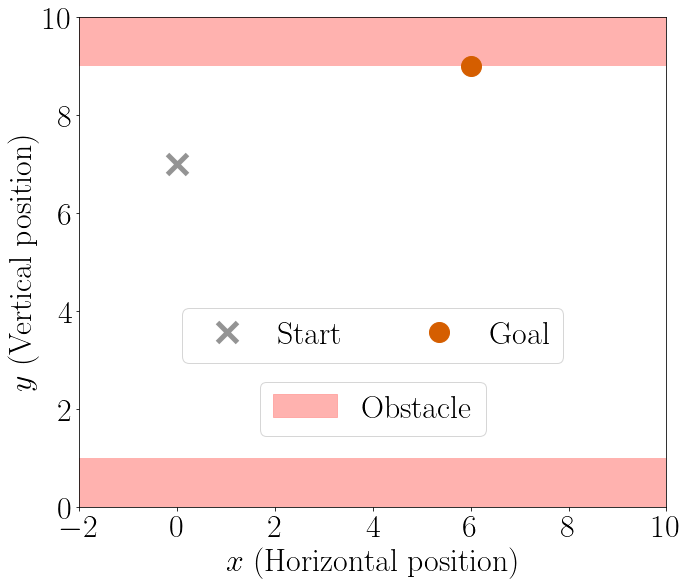

In [138]:
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
alt_colors = sns.color_palette("pastel", 9).as_hex()
pal = sns.color_palette("colorblind")
new_vals_broadcast = np.repeat(np.repeat(safe_values[np.newaxis, ...], 5, axis=0)[np.newaxis, ...], 5, axis=0)
cs = ax.contourf(extended_grid.coordinate_vectors[0], extended_grid.coordinate_vectors[2], new_vals_broadcast[:, 2, :, 13, 20, 13].T, levels=[-100, 0], colors=alt_colors[3], alpha=.8)
ax.set_xlim([-2, 10])
ax.set_xlabel('$x$ (Horizontal position)')
ax.set_ylabel('$y$ (Vertical position)')
ax.set_ylim([0, 10])

l1 = ax.plot(x0[0], x0[2], 'x', markersize=20, mew=5, color=pal[7])
# ax.plot(np.array(states_filt)[-1, 0], np.array(states_filt)[-1, 2], 'x', markersize=20, mew=5, color=c2[0].get_color())
# ax.plot(np.array(states_filt_ws)[-1, 0], np.array(states_filt_ws)[-1, 2], 'x', markersize=20, mew=5, color=c3[0].get_color())
l2 = ax.plot(x_goal[0], x_goal[2], 'o', markersize=20, color=pal[3])
miscs = [l1, l2]
proxy = []
proxy += [plt.Rectangle((0,0),1,1, fc=alt_colors[3], ec=alt_colors[3], alpha=0.8) for pc in cs.collections]
leg = ax.legend([misc[0] for misc in miscs], ['Start', 'Goal'], ncol=2, bbox_to_anchor=[.5, 0.35], loc='center', frameon=True, handletextpad=0.6)
leg2 = ax.legend(proxy, ['Obstacle'], bbox_to_anchor=[0.5, .2], loc='center', frameon=True)
ax.add_artist(leg)

ax.set_aspect(1.0)

In [139]:
fig, ani = animate_planar_quad(ts, states_filt[:,0], states_filt[:,2], states_filt[:,4], fig=fig)

In [133]:
fig, ani = animate_multi_planar_quad(ts, np.array([states_filt[:,0], states_filt_ws[:,0]]), np.array([states_filt[:,2], states_filt_ws[:,2]]), np.array([states_filt[:,4], states_filt_ws[:,4]]), fig=fig, alphas=[0.5, 1], colors=[pal[1], pal[2]])

In [134]:
ani.save("quad_2d/cbf_2.mp4")